In [3]:
!nvidia-smi

Sun Dec 28 20:14:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:85:00.0 Off |                    0 |
| N/A   30C    P0             40W /  300W |       0MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
%cd /scratch/work/muralit1/Controlnet/SemanticControl

/scratch/work/muralit1/Controlnet/SemanticControl


In [5]:
import os
from PIL import Image
from IPython.display import display

# --- These are the changed lines ---
from test.inference import EvalModel
from test.types import ModelType
# ------------------------------------

/scratch/work/muralit1/envs/semctrl/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch/work/muralit1/envs/semctrl/lib64/python3.9/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/scratch/work/muralit1/envs/semctrl/lib64/python3.9/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/scratch/work/muralit1/envs/semctrl/lib64/python3.9/site-packages/diffusers/models/transformer_2d.py:20: FutureWarning: `Transformer2DModelOutput` is

In [6]:
ref_image = Image.open("/scratch/work/muralit1/Controlnet/SemanticControl/assets/test/a woman is riding a bike.jpg")


In [7]:
# (No change here)
print("Initializing model...")
model = EvalModel(control="pose")
output_dir = "my_generated_images"
model.set_output_dir(output_dir)
print("Model initialized.")

Initializing model...


/scratch/work/muralit1/envs/semctrl/lib64/python3.9/site-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transf

Model initialized.


In [12]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.19it/s]


In [13]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320

In [8]:
# --- Imports you need ---
from test.types import ModelType  # Make sure this import is in your notebook
from PIL import Image
from IPython.display import display

# --- Download an example pose image ---
# !wget https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/images/img2.png -O reference_pose.png

# Display the reference image
print("This is your reference image:")
ref_image = Image.open("/scratch/work/muralit1/Controlnet/SemanticControl/assets/test/a woman is riding a bike.jpg")
# display(ref_image)

This is your reference image:


In [9]:
# 1. Get the specific inference function you want
inference_func = model.get_inference_func(ModelType.SemanticControl)

# 2. Define your generation parameters
prompt = "A cat holding a guitar"          # <-- CHANGED: Describe the final image
mask_prompt = "A man holding a guitar"                              # <-- What to replace from the reference
focus_tokens = "holding a guitar"                             # <-- What to replace from the reference
reference_image_path = "/scratch/work/muralit1/Controlnet/SemanticControl/assets/test/a man is holding the guitar.jpg"
ref_subject = "man"                              # The subject in the reference image
prompt_subject = "cat"  
seed = 42

print(f"Generating image for: {prompt}")

# 3. Run the generation
# This will take some time
generated_image = inference_func(
    prompt=prompt,
    reference=reference_image_path,
    ref_subj=ref_subject,
    prmpt_subj=prompt_subject,
    seed=seed,
    mask_prompt=mask_prompt,
    focus_tokens=focus_tokens,
    save_attn=False
)

print("Generation complete.")

Generating image for: A cat holding a guitar
my_generated_images/man/cat/A cat holding a guitar/SemanticControl/pose/seed 42.png is already generated. Skipping.
Generation complete.


In [10]:
# Make sure these are imported at the top of your notebook
from PIL import Image
from IPython.display import display

if generated_image:
    # This function saves the grid you want
    model.postprocess(generated_image, save_attn=False)
else:
    print("Image was not generated (it may have already existed and was skipped).")

Image was not generated (it may have already existed and was skipped).


Comparison (Reference | Control | Output):


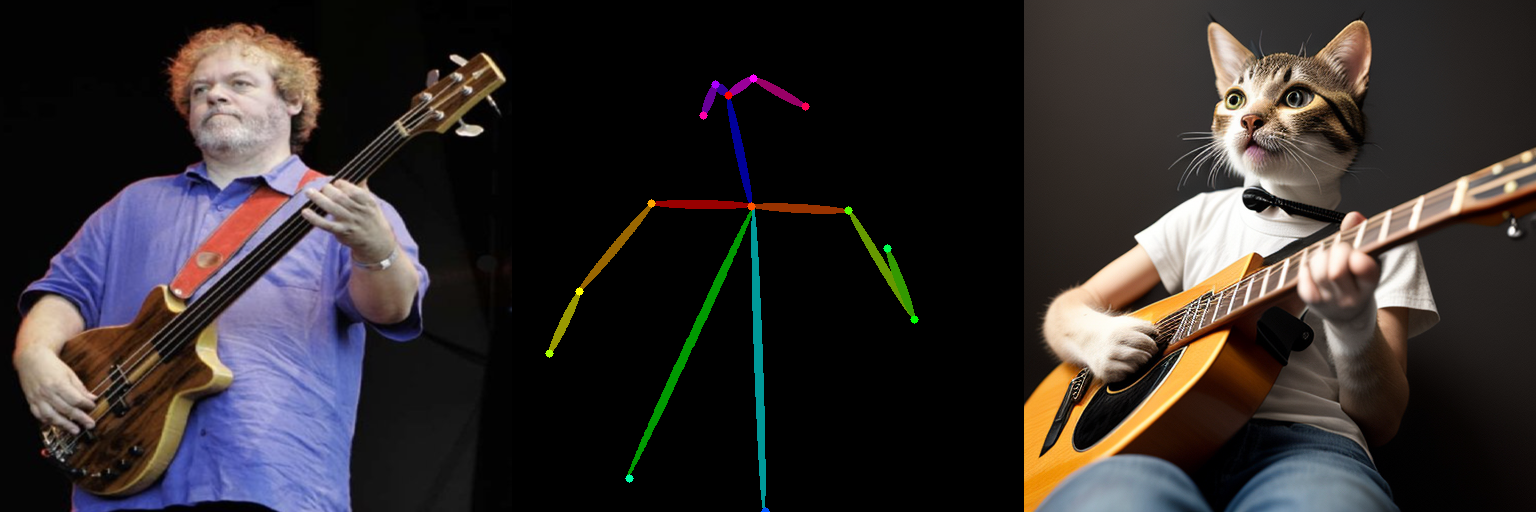

In [11]:
# This path is constructed by the postprocess method
# Make sure the 'seed' variable (e.g., 42) is the same one you used for inference
comparison_path = f"{model.save_dir}/{model.control} control result - seed {seed}.png"

if os.path.exists(comparison_path):
    print("Comparison (Reference | Control | Output):")
    display(Image.open(comparison_path))
else:
    print(f"Could not find comparison image at: {comparison_path}")